In [1]:
import torch_geometric
import tsl
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import gravis as gv
import networkx as nx

from tsl.datasets import PvUS
from tsl.data.datamodule import SpatioTemporalDataModule, TemporalSplitter
from tsl.data.preprocessing import StandardScaler
from scipy.stats import levene, ttest_ind
from tqdm import trange

c:\Users\mgphy\anaconda3\envs\koopman\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mgphy\anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
dataset = PvUS(root="/dataset", zones=['west'])
print(dataset)
print(f"Default similarity: {dataset.similarity_score}")
print(f"Available similarity options: {dataset.similarity_options}")
print("==========================================")

sim = dataset.get_similarity("distance")

connectivity = dataset.get_connectivity(threshold=0.7,
                                        include_self=False,
                                        normalize_axis=1,
                                        layout="edge_index")
edge_index, edge_weight = connectivity

print(f'edge_index {edge_index.shape}')
print(f'edge_weight {edge_weight.shape}')
print("==========================================")


torch_dataset = tsl.data.SpatioTemporalDataset(target=dataset.dataframe(),
                                      connectivity=connectivity,
                                      mask=dataset.mask,
                                      horizon=1,
                                      window=1,
                                      stride=1)
print(torch_dataset)
print("==========================================")

sample = torch_dataset[0]
print(sample)
print(sample.pattern)
print("==========================================")

PvUS-west(length=52560, n_nodes=1082, n_channels=1)
Default similarity: distance
Available similarity options: {'distance', 'correntropy'}
edge_index (2, 41502)
edge_weight (41502,)
SpatioTemporalDataset(n_samples=52559, n_nodes=1082, n_channels=1)
Data(
  input=(x=[t=1, n=1082, f=1], edge_index=[2, e=41502], edge_weight=[e=41502]),
  target=(y=[t=1, n=1082, f=1]),
  has_mask=False
)
{'x': 't n f', 'edge_index': '2 e', 'edge_weight': 'e', 'y': 't n f'}


In [3]:
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)

dm.setup()
print(dm)

SpatioTemporalDataModule(train_len=37843, val_len=4203, test_len=10511, scalers=[target], batch_size=64)


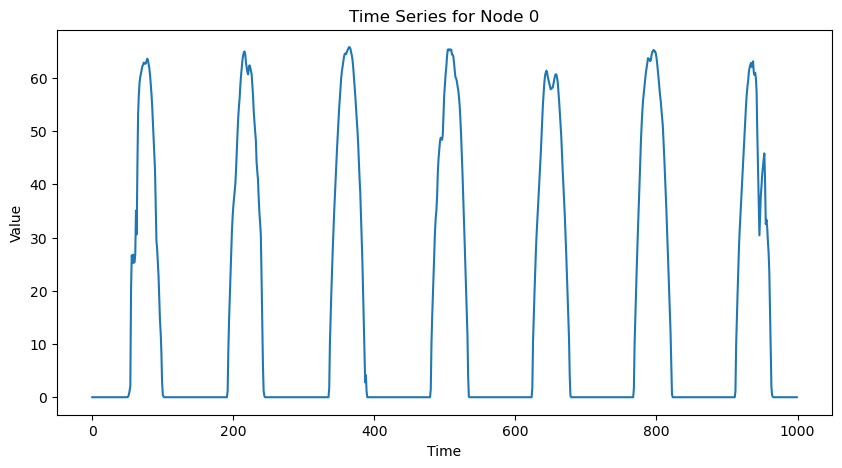

In [4]:
# Choose the index of the node you want to plot
node_index = 0

# Plot the time series
plt.figure(figsize=(10, 5)) 
plt.plot(dataset.target.to_numpy()[:1000,node_index])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series for Node {node_index}')
plt.show()


Levene's test:

In [5]:
time_series_list = []
for node_index in range(dataset.target.shape[1]):
    time_series = dataset.target.to_numpy()[:, node_index]
    time_series_list.append(time_series)

In [ ]:
stat, p_value = levene(*time_series_list)

print(f"Levene's test results:")
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")
print("==========================================")

It seems that some variances are very different.

We can make compare pairs of nodes.

In [12]:
num_nodes = dataset.target.shape[1]
p_value_matrix = np.zeros((num_nodes, num_nodes))

p_values = []

# Add progress bar
for i in trange(num_nodes):
    for j in range(i+1, num_nodes):
        _, p_value = ttest_ind(time_series_list[i], time_series_list[j], equal_var=False)
        p_value_matrix[i,j] = p_value

100%|██████████| 1082/1082 [03:47<00:00,  4.76it/s]


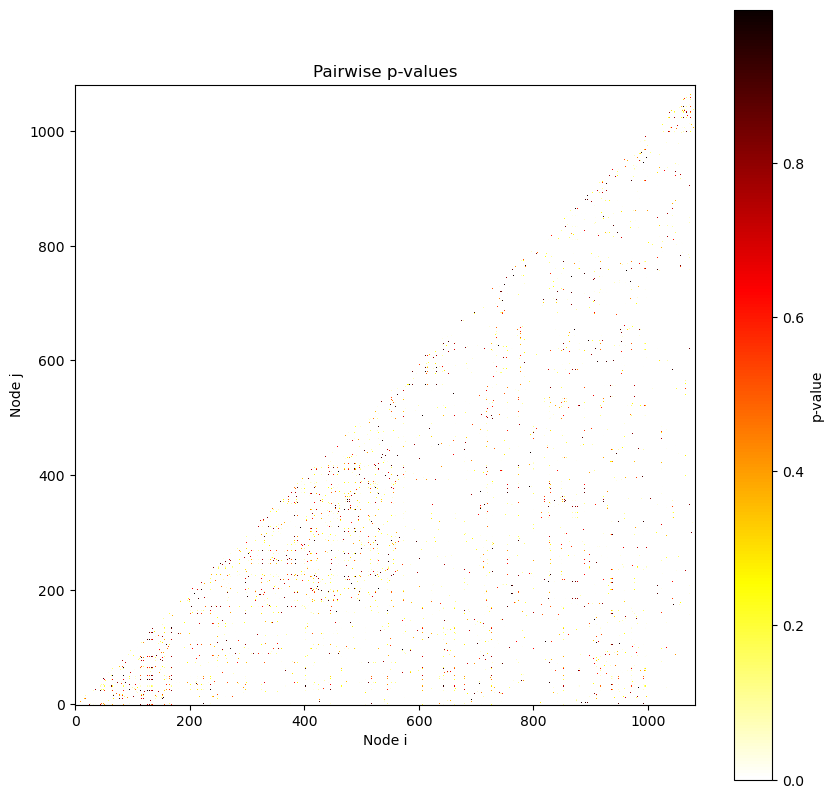

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(p_value_matrix, cmap='hot_r', interpolation='nearest')
plt.colorbar(label='p-value')
plt.xlabel('Node i')
plt.ylabel('Node j')
plt.title('Pairwise p-values')

# Flip the y-axis
plt.gca().invert_yaxis()

plt.show()

Auto cross-correlation for seasonality

In [7]:
auto_corr_list = []

# Iterate over each node
for node_index in trange(dataset.target.shape[1]):
    # Get the time series data for the node
    time_series = time_series_list[node_index]
    
    # Calculate the auto cross-correlation
    auto_corr = np.correlate(time_series, time_series, mode='full')
    auto_corr_list.append(auto_corr)

stacked_auto_corr = np.stack(auto_corr_list)


100%|██████████| 1082/1082 [08:31<00:00,  2.12it/s]


In [36]:
def plot_auto_correlation(stacked_auto_corr, cut=1500, seasonality=144):
    plt.figure(figsize=(10, 5))

    for series in stacked_auto_corr[:10]:
        plt.plot(series[:cut])

    # Add vertical lines for multiples of seasonality
    for i in range(1, cut // seasonality + 1):
        plt.axvline(x=i * seasonality, color='red', linestyle='--')

    plt.xlabel('Lag')
    plt.ylabel('Auto Correlation')
    plt.title('Auto Correlation for All Series')
    plt.show()

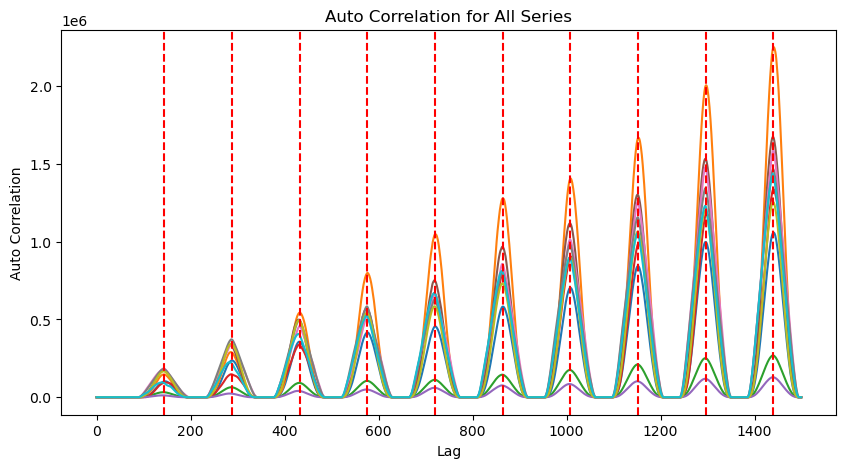

In [37]:
plot_auto_correlation(stacked_auto_corr)

In [34]:
def plot_average_auto_corr(auto_corr_array, cut, seasonality):
    plt.figure(figsize=(10, 5))

    # Calculate the average and standard deviation of auto_corr_list
    average_auto_corr = np.mean(auto_corr_array, axis=0)
    std_auto_corr = np.std(auto_corr_array, axis=0)

    # Plot the average with shaded area for the first 1000 steps
    plt.plot(range(len(average_auto_corr[:cut])), average_auto_corr[:cut])
    plt.fill_between(range(len(average_auto_corr[:cut])), average_auto_corr[:cut] - std_auto_corr[:cut], average_auto_corr[:cut] + std_auto_corr[:cut], alpha=0.6)

    # Add vertical lines for multiples of seasonality
    for i in range(1, cut // seasonality + 1):
        plt.axvline(x=i * seasonality, color='red', linestyle='--')

    plt.xlabel('Lag')
    plt.ylabel('Auto Correlation')
    plt.title('Average Auto Correlation with std')
    plt.show()


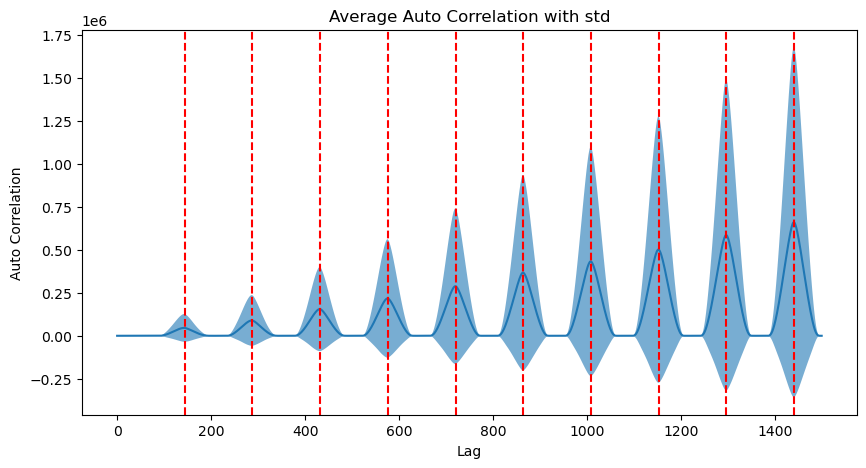

In [35]:
plot_average_auto_corr(stacked_auto_corr, cut=1500, seasonality=144)

In [18]:
time_series_array = np.stack(time_series_list)

# Remove the 144 steps seasonality
time_series_day = time_series_array[:,:-144] - time_series_array[:,144:]

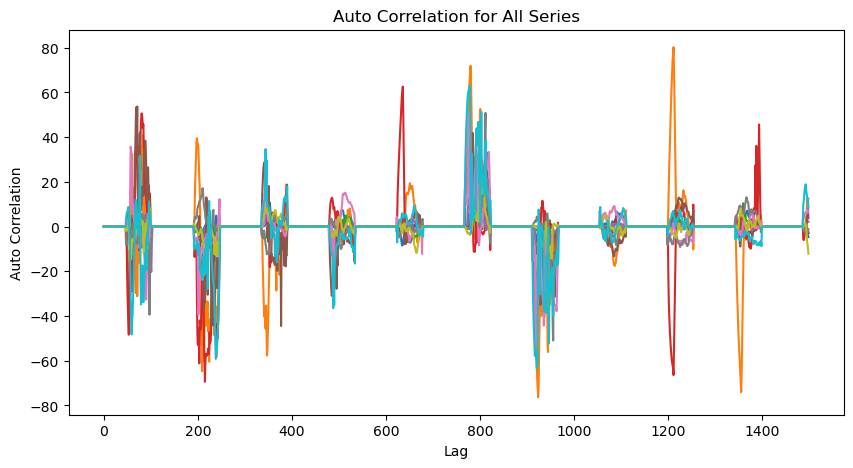

In [42]:
plot_auto_correlation(time_series_day, cut=1500, seasonality=10000)

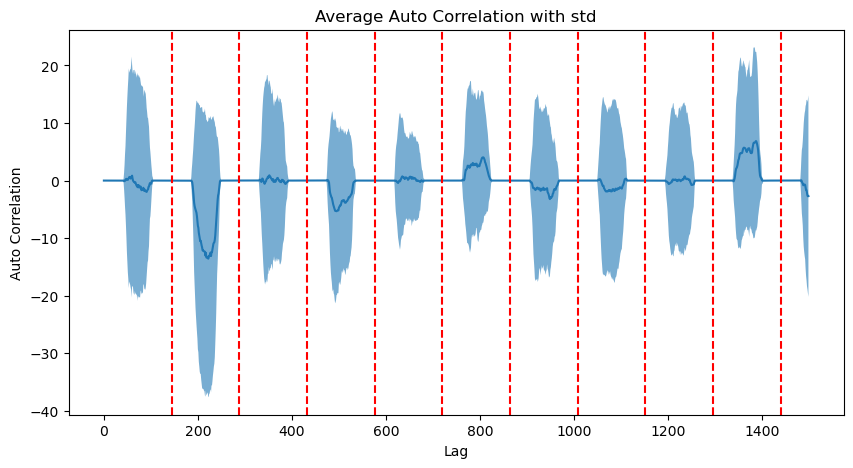

In [33]:
plot_average_auto_corr(time_series_day, cut=1500)

There is a very strong daily (144 steps) seasonality.

Export graph for Gephi and visualise it

In [6]:
from utils.gephi import create_dynamic_gexf

In [7]:
create_dynamic_gexf(edge_index, dataset, output_file="pvus_dynamic.gexf", input_file="pvus.gexf", max_T=2000)

100%|██████████| 1076/1076 [00:16<00:00, 66.61it/s]


In [32]:
# Plot the graph
graph = nx.Graph()
graph.graph['node_color'] = 'cyan'
graph.add_edges_from(sample.edge_index[:,:500].T)

gv.vis(graph, show_node_label=False, show_edge_label=False)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

data = torch_geometric.data.Data(x=sample.x, edge_index=sample.edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
pos = nx.nx_agraph.graphviz_layout(g)
nx.draw(pos, **options)